Implementing the U Net architecture

Steps:
1. Get the data
2. May have to preprocess (add augmentation, clean etc.)
3. Create test, train sets and dataloaders
4. Create a model
5. Train

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim


Getting the data:

Using git

In [ ]:
# Clone the repository
!git clone https://github.com/shimchu/carvana-dataset

# Change directory to the dataset folder
%cd carvana-dataset



Cloning into 'carvana-dataset'...
remote: Enumerating objects: 10183, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 10183 (delta 0), reused 3 (delta 0), pack-reused 10180
Receiving objects: 100% (10183/10183), 436.05 MiB | 27.38 MiB/s, done.
Updating files: 100% (10177/10177), done.
/content/carvana-dataset


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


In [ ]:

class CarvanaDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.images = os.listdir(images_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_path, img_name)
        mask_path = os.path.join(self.masks_path, img_name.replace('.jpg', '_mask.gif'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Set paths
train_images_path = './train'
train_masks_path = './train_masks'

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),                                      #resize
    transforms.ToTensor()
])

# Create the full dataset
full_dataset = CarvanaDataset(train_images_path, train_masks_path, transform=transform)

# Define the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
# torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False, num_workers=2)

# Check a batch of data from the train loader
images, masks = next(iter(train_loader))
print(images.shape, masks.shape)

# Check a batch of data from the test loader
test_images, test_masks = next(iter(test_loader))
print(test_images.shape, test_masks.shape)


Train dataset size: 4070
Test dataset size: 1018
torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])


In [ ]:

import os

train_dir = './train'
train_masks_dir = './train_masks'

num_train_images = len([name for name in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, name))])
num_train_masks = len([name for name in os.listdir(train_masks_dir) if os.path.isfile(os.path.join(train_masks_dir, name))])

print(f"Number of images in train folder: {num_train_images}")
print(f"Number of images in train_masks folder: {num_train_masks}")

Number of images in train folder: 5088
Number of images in train_masks folder: 5088


MODEL:

In [ ]:
import torch
import torch.nn as nn


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def double_conv(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta: tensor_size - delta, delta: tensor_size - delta]

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(1, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(512, 256)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(256, 128)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        self.features = {}

    def forward(self, image):
        x1 = self.down_conv_1(image)
        self.features['enc1'] = x1
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        self.features['enc2'] = x3
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        self.features['enc3'] = x5
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        self.features['enc4'] = x7
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)
        self.features['bottleneck'] = x9

        x = self.up_trans_1(x9)
        y = crop_img(x7, x)
        x = self.up_conv_1(torch.cat([x, y], 1))
        self.features['dec4'] = x

        x = self.up_trans_2(x)
        y = crop_img(x5, x)
        x = self.up_conv_2(torch.cat([x, y], 1))
        self.features['dec3'] = x

        x = self.up_trans_3(x)
        y = crop_img(x3, x)
        x = self.up_conv_3(torch.cat([x, y], 1))
        self.features['dec2'] = x

        x = self.up_trans_4(x)
        y = crop_img(x1, x)
        x = self.up_conv_4(torch.cat([x, y], 1))
        self.features['dec1'] = x

        x = self.out(x)
        self.features['output'] = x
        return x



Train:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm
from timeit import default_timer as timer
start_time = timer()

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20  # Set the number of epochs as 22

for epoch in tqdm(range(num_epochs)):
    model.train()
    training_running_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, masks)
        training_running_loss += loss.item()
        loss.backward()
        optimizer.step()


    epoch_loss = training_running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Optional: Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_total_pixels = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize the masks to match the output size
            masks_resized = torch.nn.functional.interpolate(masks, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks_resized)
            test_loss += loss.item() * images.size(0)

            # Calculate accuracy
            preds = outputs > 0.5
            test_corrects += torch.sum(preds == masks_resized)
            test_total_pixels += masks_resized.numel()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects.double() / test_total_pixels
        print(f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')



# Save the trained model
torch.save(model.state_dict(), 'unet_carvana.pth')

# End the timer and print out how long it took
end_time = timer()
print(timer())

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.0083
Test Loss: 0.3614, Test Accuracy: 0.7727
Epoch 2/20, Loss: 0.0035
Test Loss: 0.1140, Test Accuracy: 0.9340
Epoch 3/20, Loss: 0.0016
Test Loss: 0.0934, Test Accuracy: 0.9459
Epoch 4/20, Loss: 0.0012
Test Loss: 0.0635, Test Accuracy: 0.9534
Epoch 5/20, Loss: 0.0010
Test Loss: 0.0588, Test Accuracy: 0.9579
Epoch 6/20, Loss: 0.0008
Test Loss: 0.0481, Test Accuracy: 0.9590
Epoch 7/20, Loss: 0.0007
Test Loss: 0.0426, Test Accuracy: 0.9608
Epoch 8/20, Loss: 0.0006
Test Loss: 0.0401, Test Accuracy: 0.9633
Epoch 9/20, Loss: 0.0006
Test Loss: 0.0347, Test Accuracy: 0.9644
Epoch 10/20, Loss: 0.0005
Test Loss: 0.0326, Test Accuracy: 0.9644
Epoch 11/20, Loss: 0.0005
Test Loss: 0.0308, Test Accuracy: 0.9648
Epoch 12/20, Loss: 0.0005
Test Loss: 0.0289, Test Accuracy: 0.9657
Epoch 13/20, Loss: 0.0005
Test Loss: 0.0291, Test Accuracy: 0.9655
Epoch 14/20, Loss: 0.0004
Test Loss: 0.0280, Test Accuracy: 0.9655
Epoch 15/20, Loss: 0.0004
Test Loss: 0.0271, Test Accuracy: 0.9659
Epoc

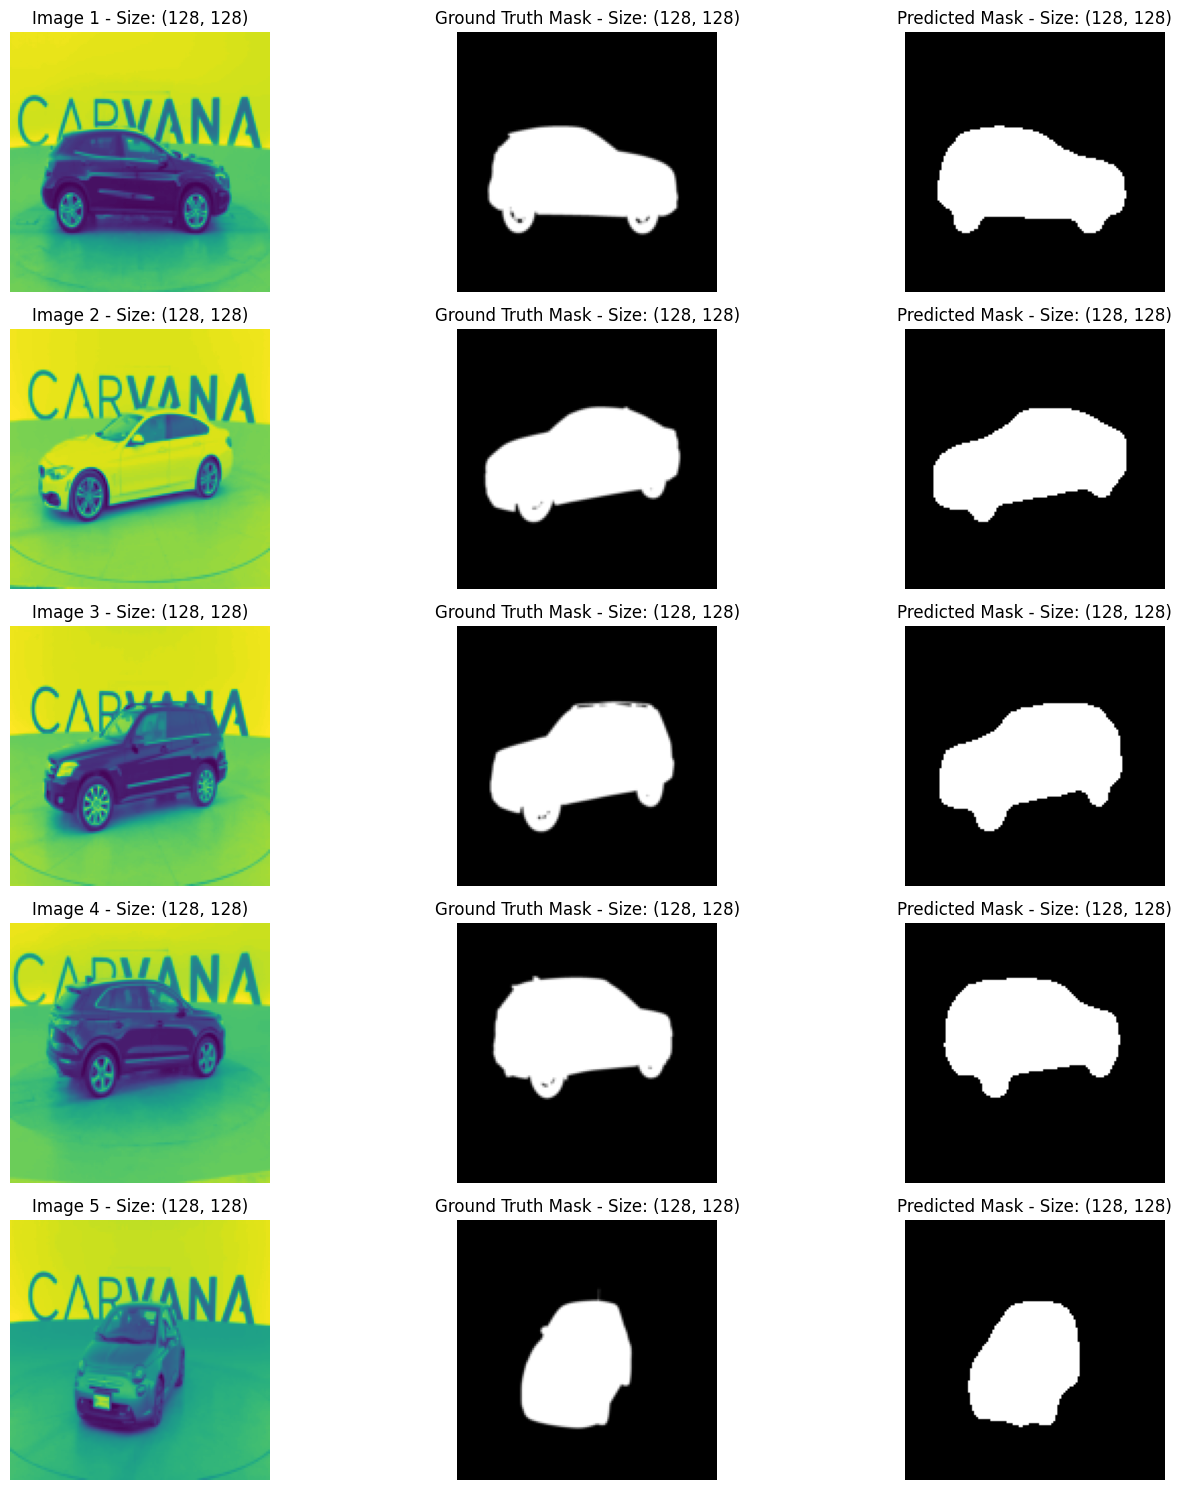

In [ ]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Function to visualize images, masks, and predictions
def visualize_random_images(model, dataset, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Select random images and their masks
    random_indices = random.sample(range(len(dataset)), num_images)

    fig, axs = plt.subplots(num_images, 3, figsize=(15, 15))

    for i, idx in enumerate(random_indices):
        # Get the image and mask from dataset
        image, mask = dataset[idx]

        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(device)

        # Predict mask
        with torch.no_grad():
            output = model(image)
            predicted_mask = torch.sigmoid(output).squeeze(0)
            predicted_mask = (predicted_mask > 0.5).float()  # Threshold at 0.5

        # Convert tensors to numpy arrays for visualization
        image_np = TF.to_pil_image(image.cpu().squeeze(0))
        mask_np = TF.to_pil_image(mask.cpu())
        predicted_mask_np = TF.to_pil_image(predicted_mask.cpu())

        # Display original image, ground truth mask, and predicted mask
        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title(f"Image {i+1} - Size: {image_np.size}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(mask_np, cmap='gray')
        axs[i, 1].set_title(f"Ground Truth Mask - Size: {mask_np.size}")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predicted_mask_np, cmap='gray')
        axs[i, 2].set_title(f"Predicted Mask - Size: {predicted_mask_np.size}")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
visualize_random_images(model, test_dataset)

In [ ]:
import requests
# checking number of files displayed in api/ website

# Replace with your repository information
owner = 'shimchu'
repo = 'carvana-dataset'
folder1 = 'train'
folder2 = 'train_masks'

def count_images_in_folder(owner, repo, folder):
    api_url = f'https://api.github.com/repos/{owner}/{repo}/contents/{folder}'
    response = requests.get(api_url)
    if response.status_code == 200:
        contents = response.json()
        image_count = 0
        for item in contents:
            if item['type'] == 'file' and item['name'].lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                image_count += 1
        return image_count
    else:
        print(f"Error: {response.status_code}")
        return 0

train_image_count = count_images_in_folder(owner, repo, folder1)
train_masks_image_count = count_images_in_folder(owner, repo, folder2)

print(f'Total images in {folder1} folder: {train_image_count}')
print(f'Total images in {folder2} folder: {train_masks_image_count}')

Total images in train folder: 1000
Total images in train_masks folder: 1000


Visualizing a random image and its feature maps from the training dataset:


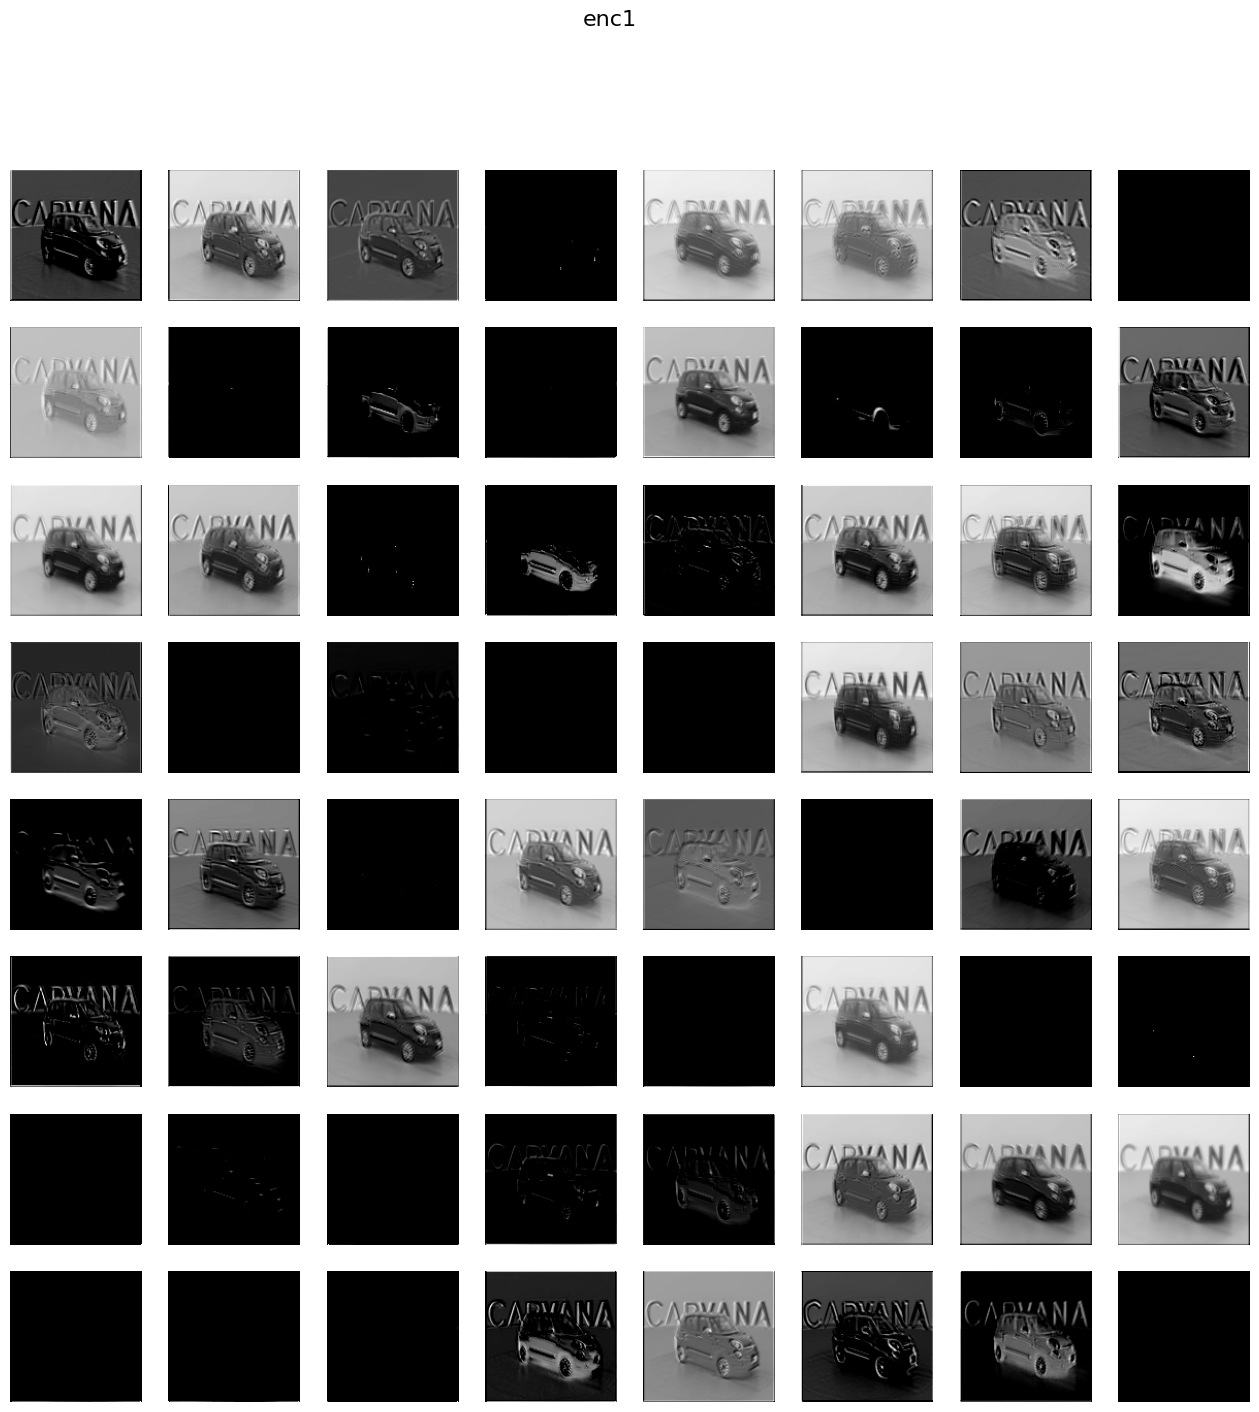

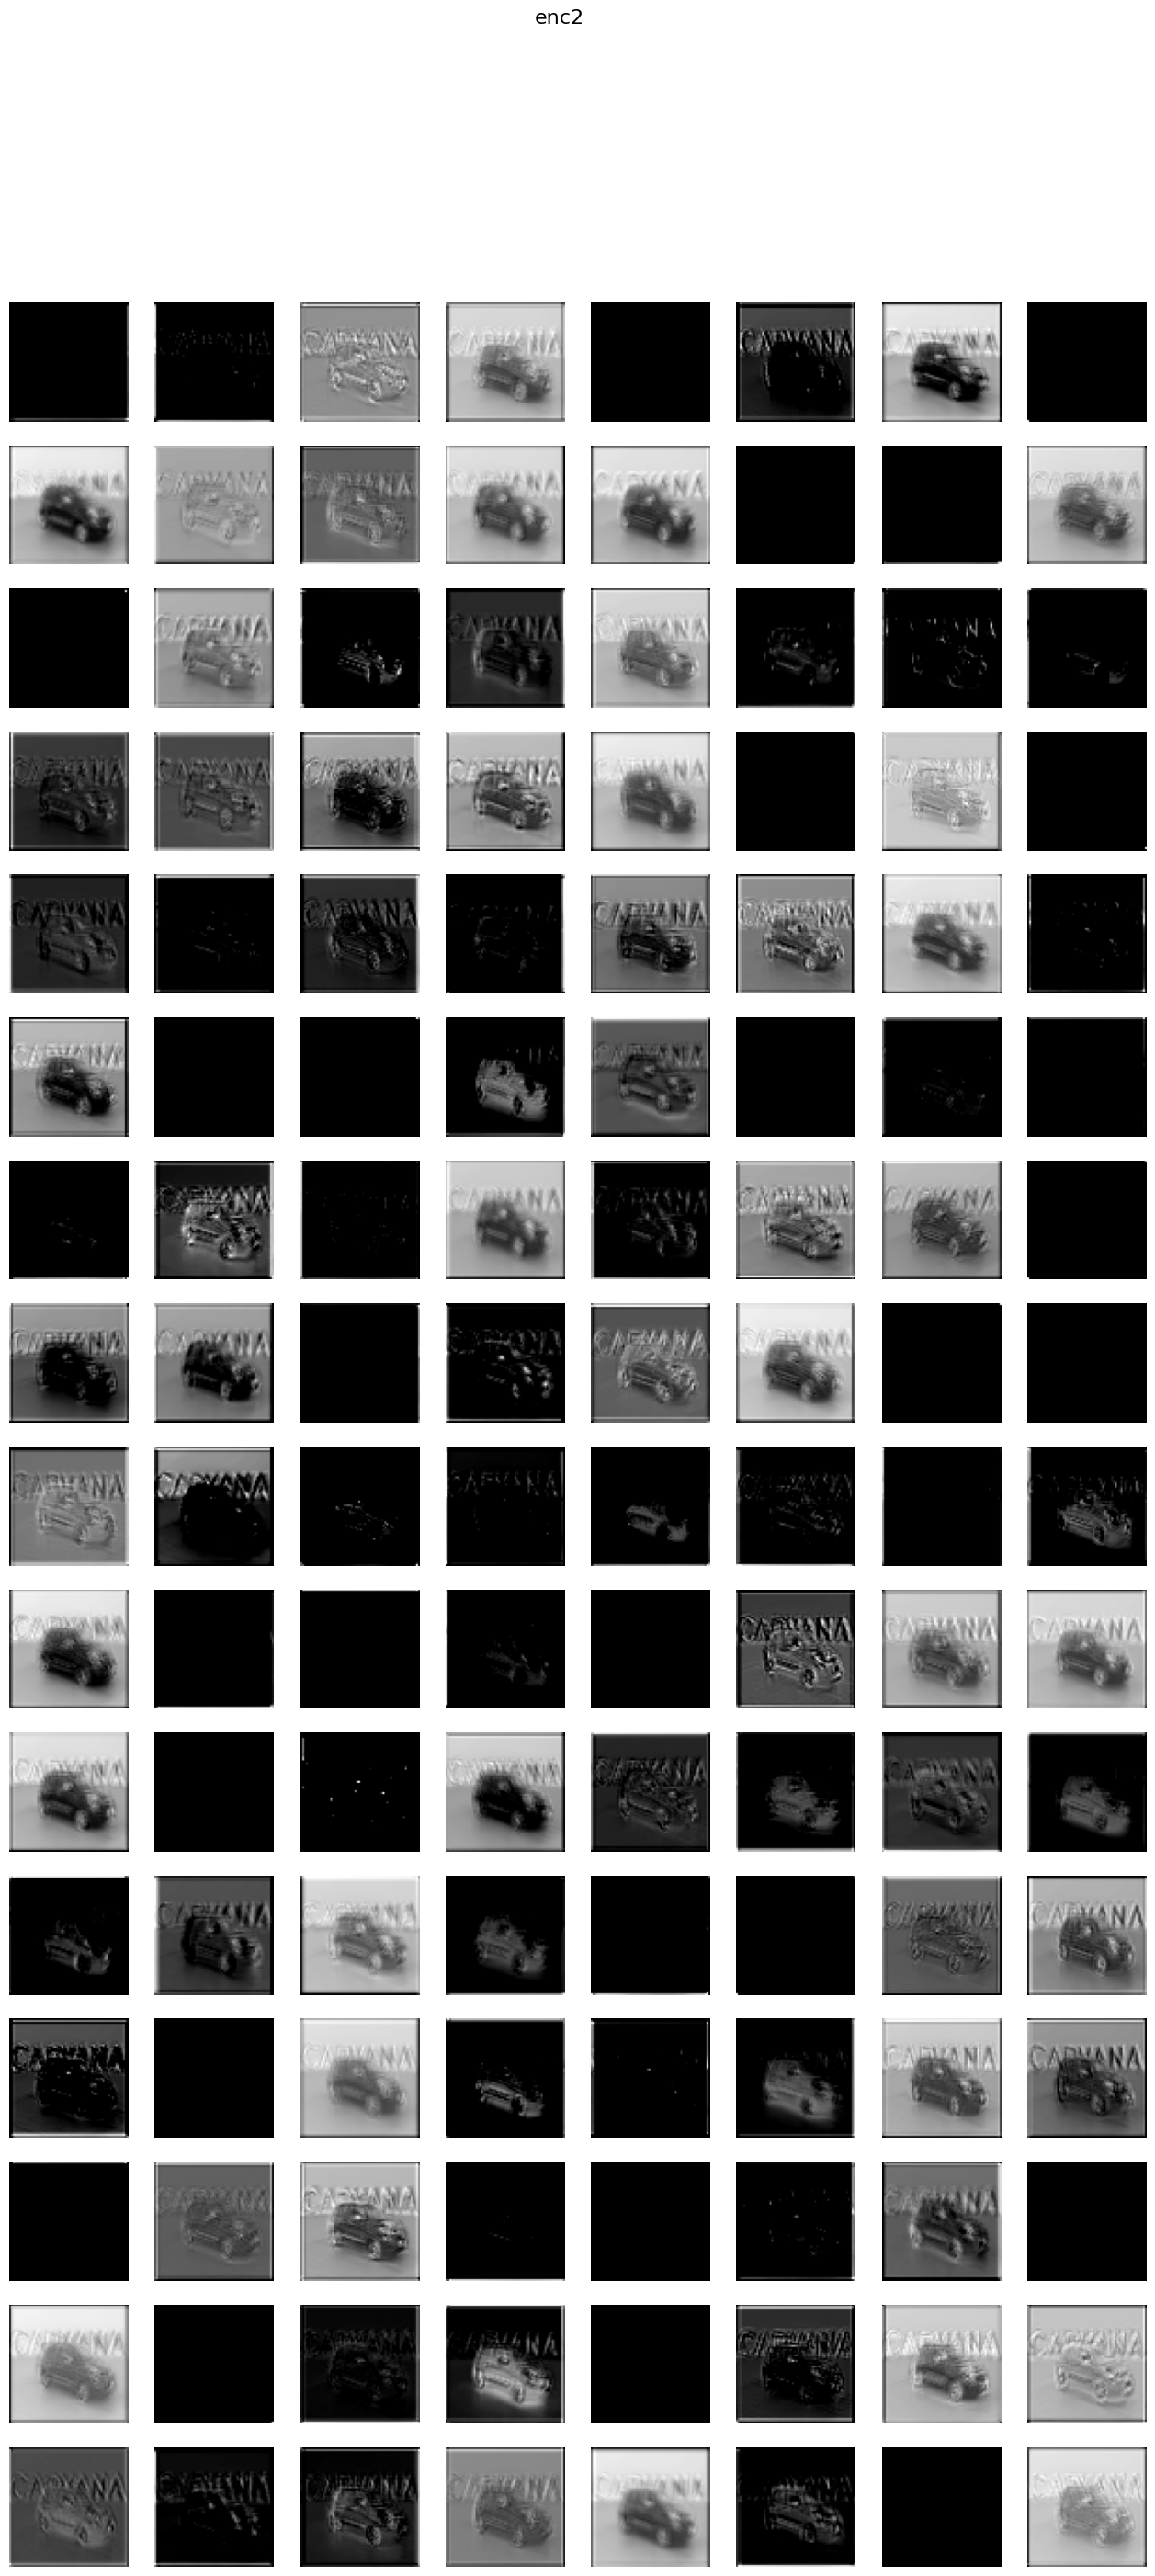

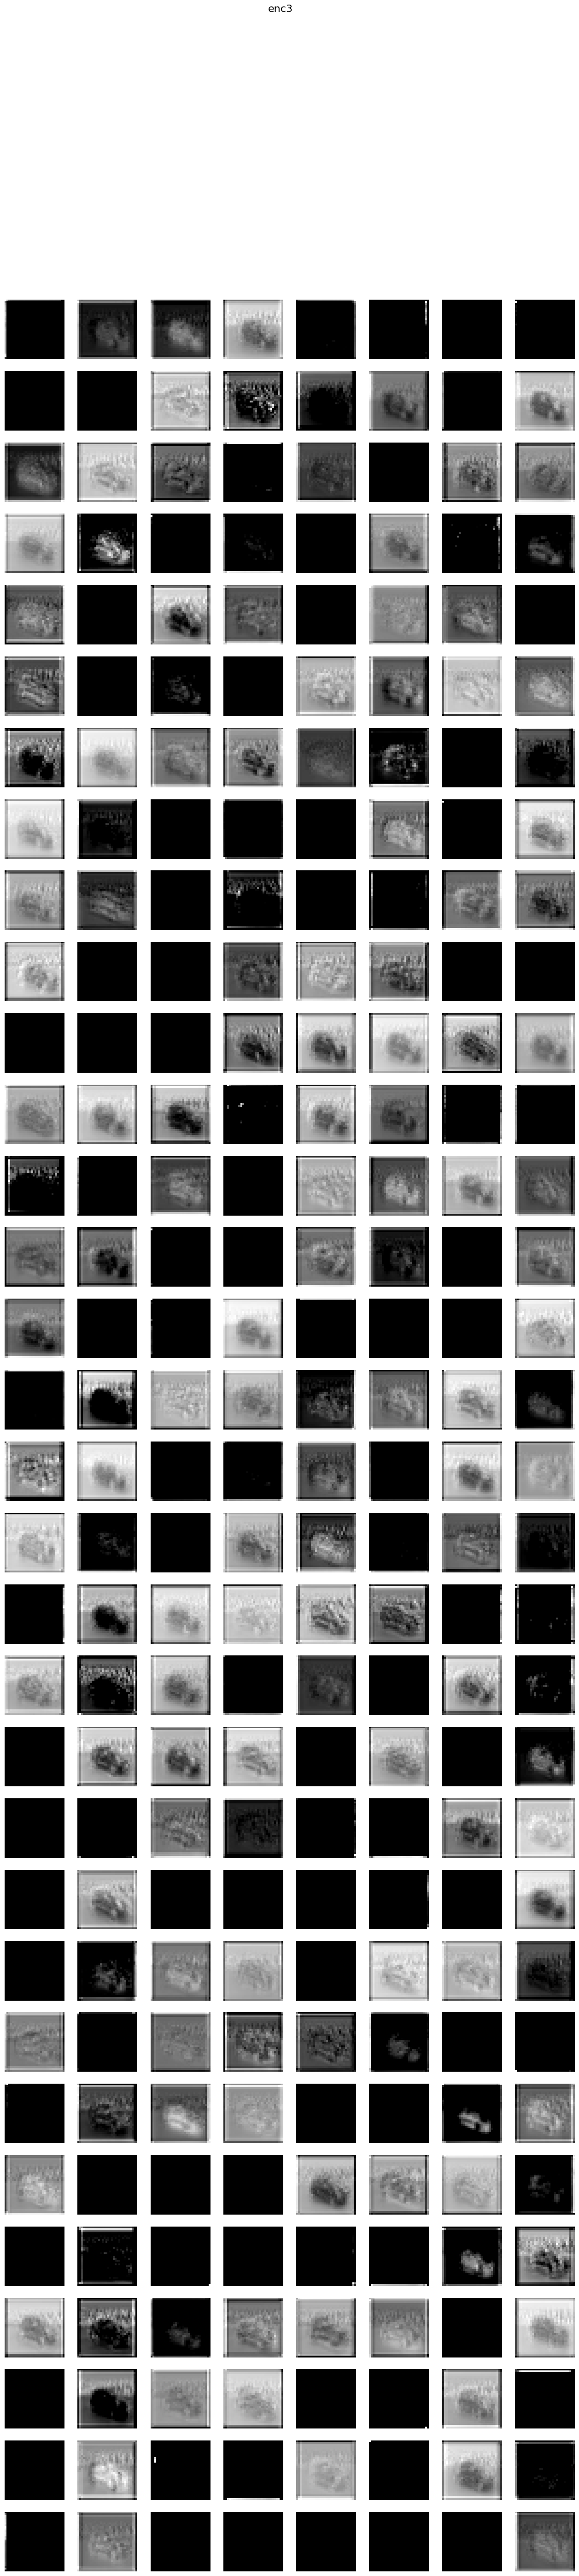

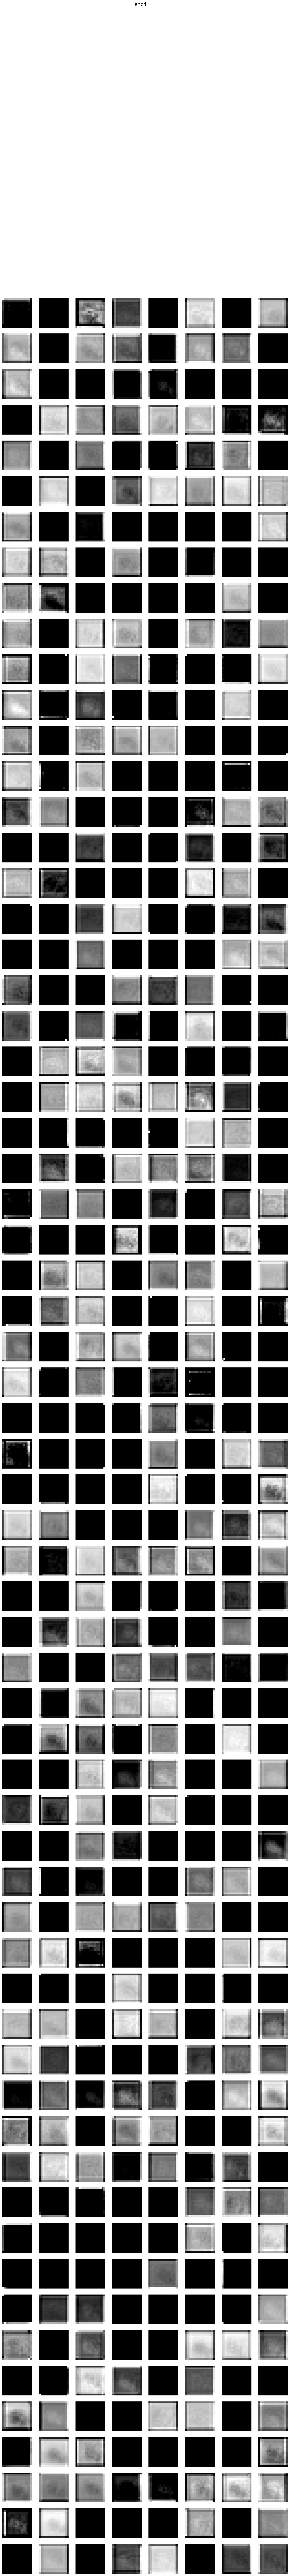

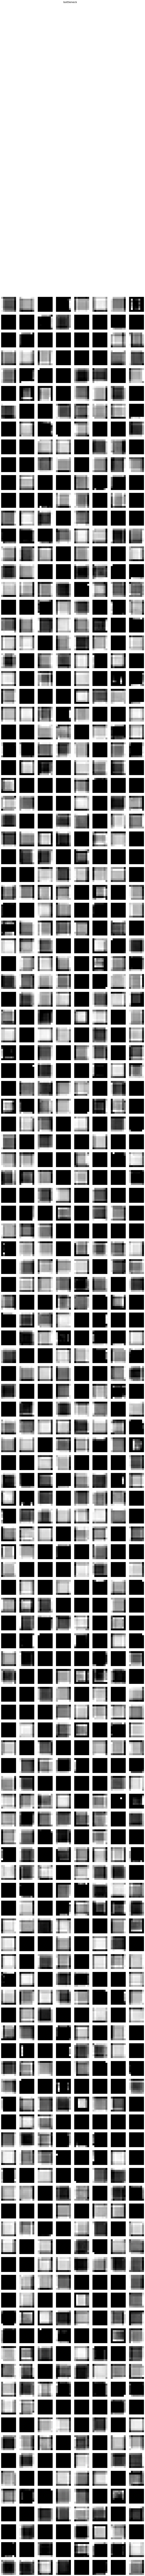

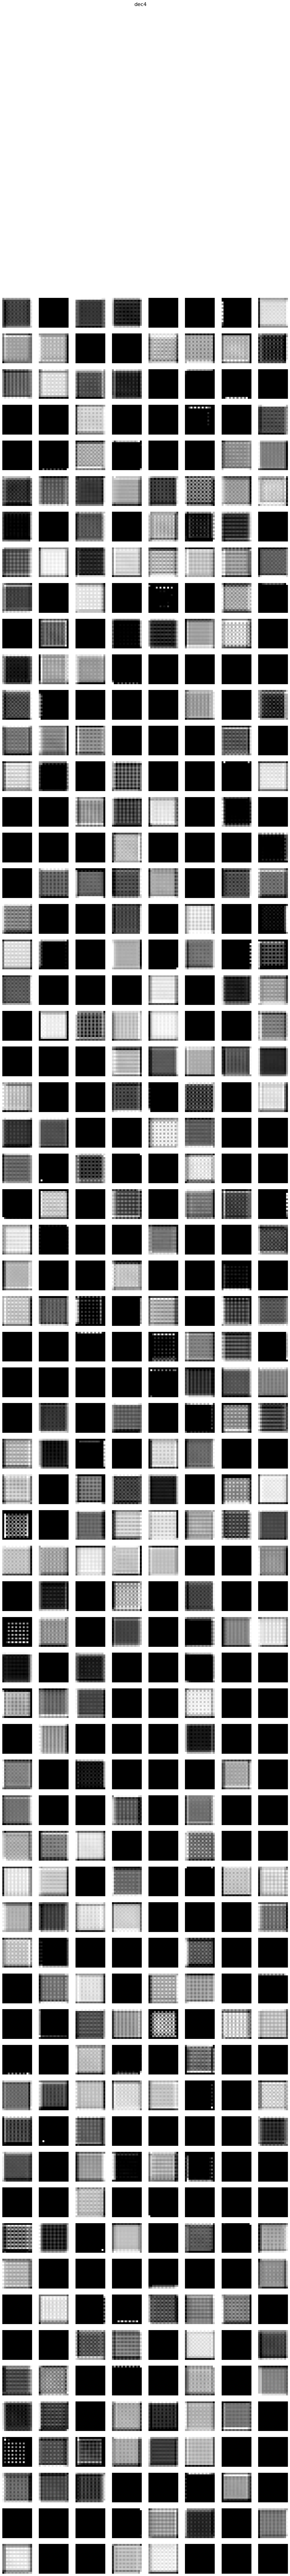

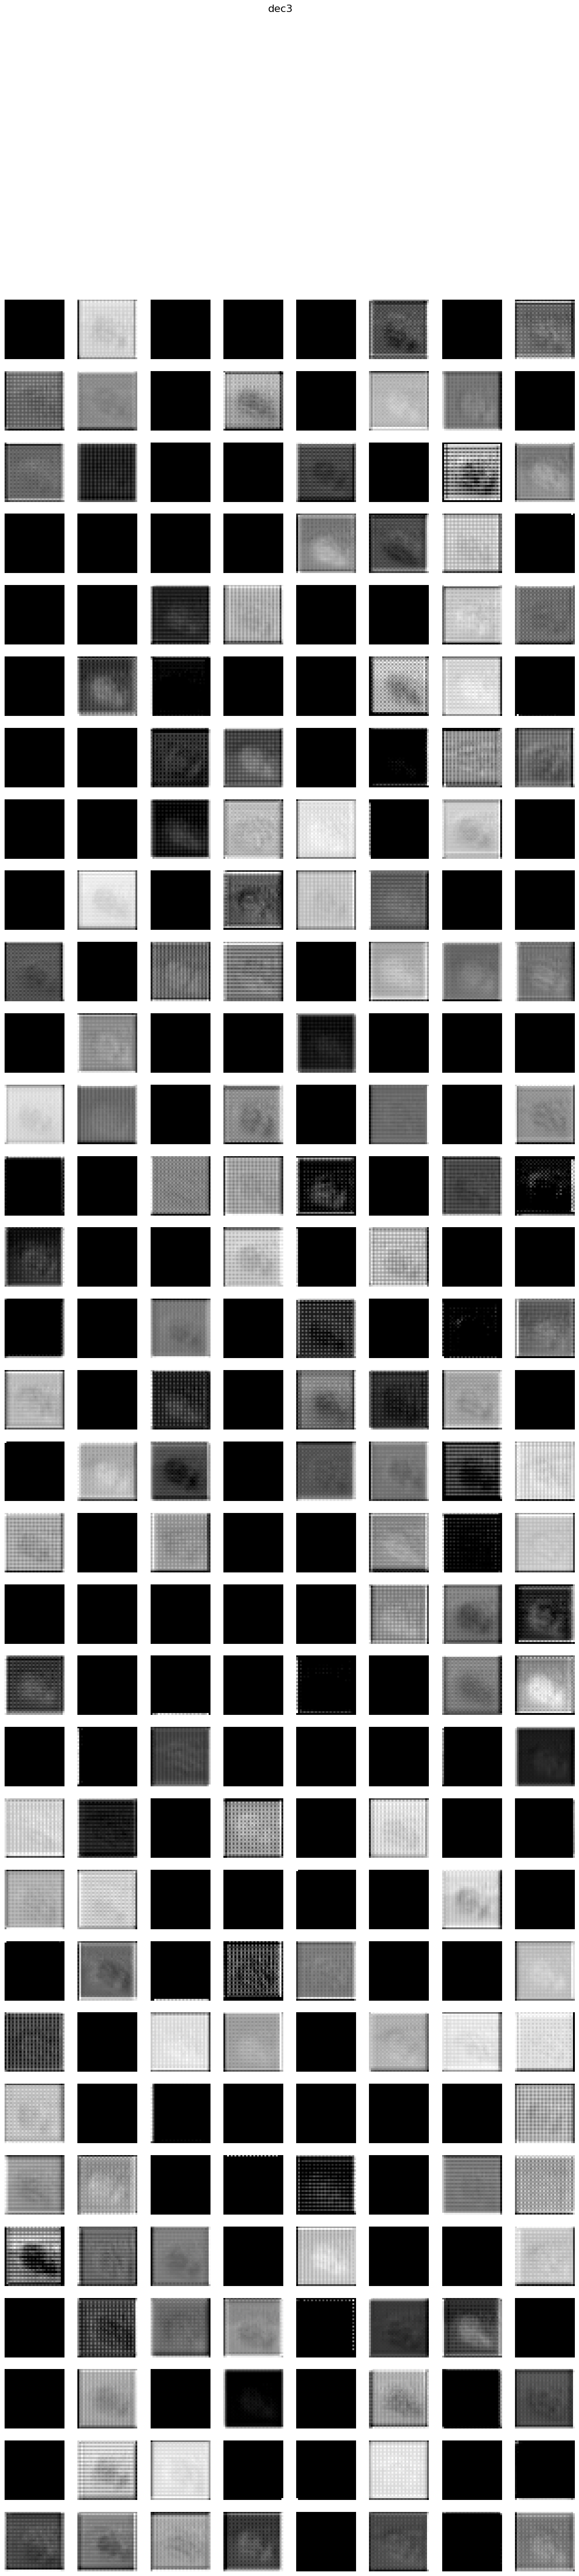

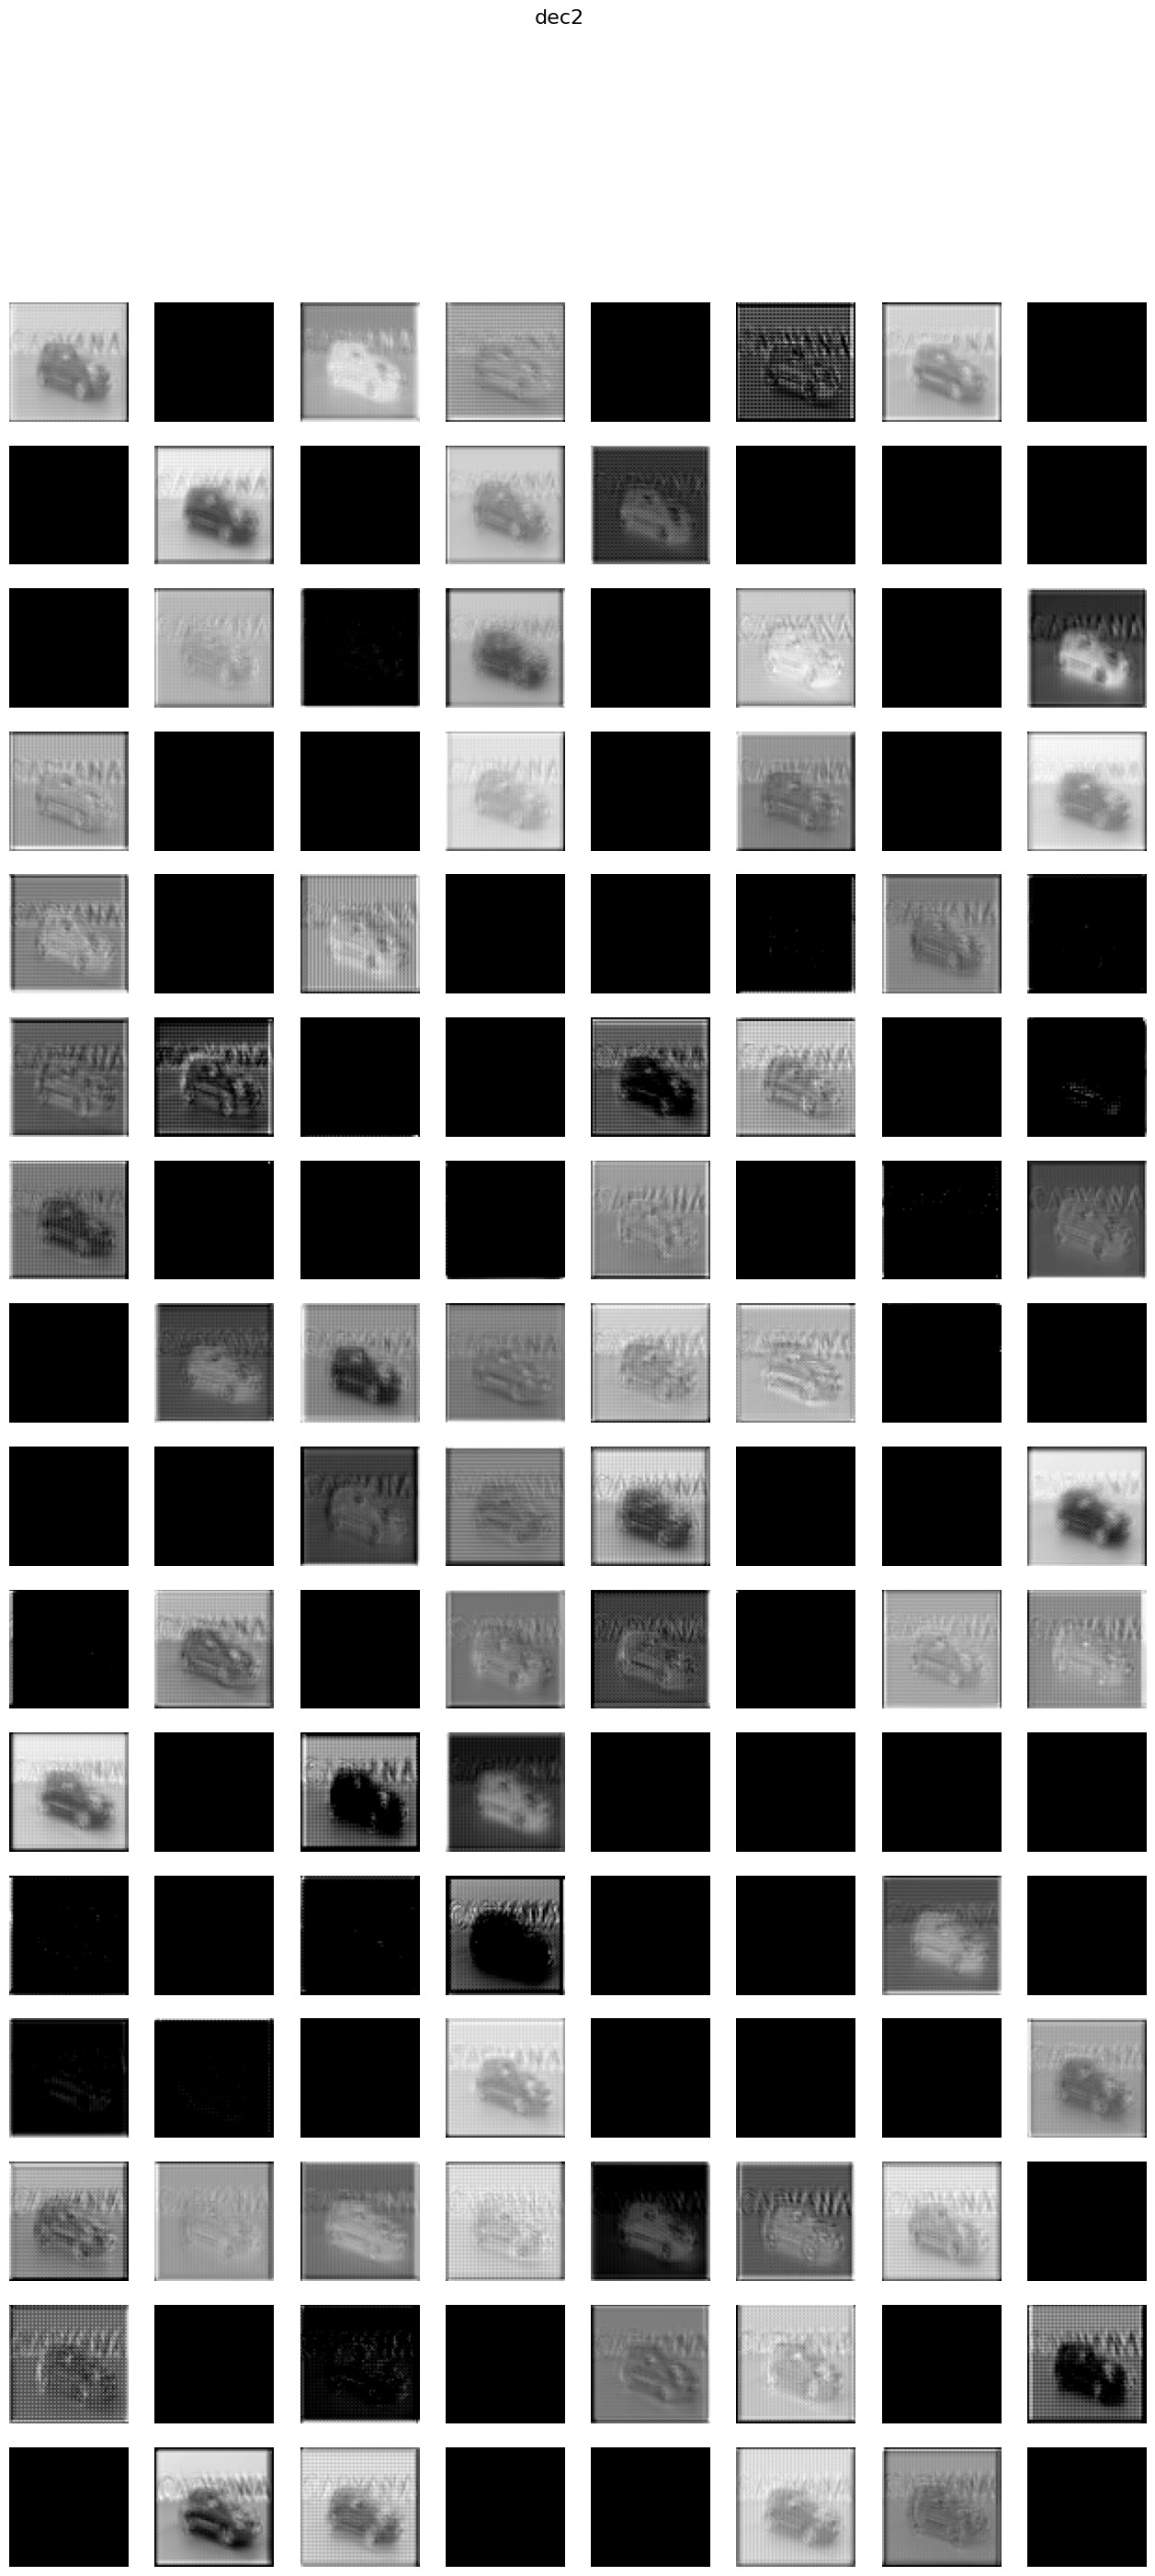

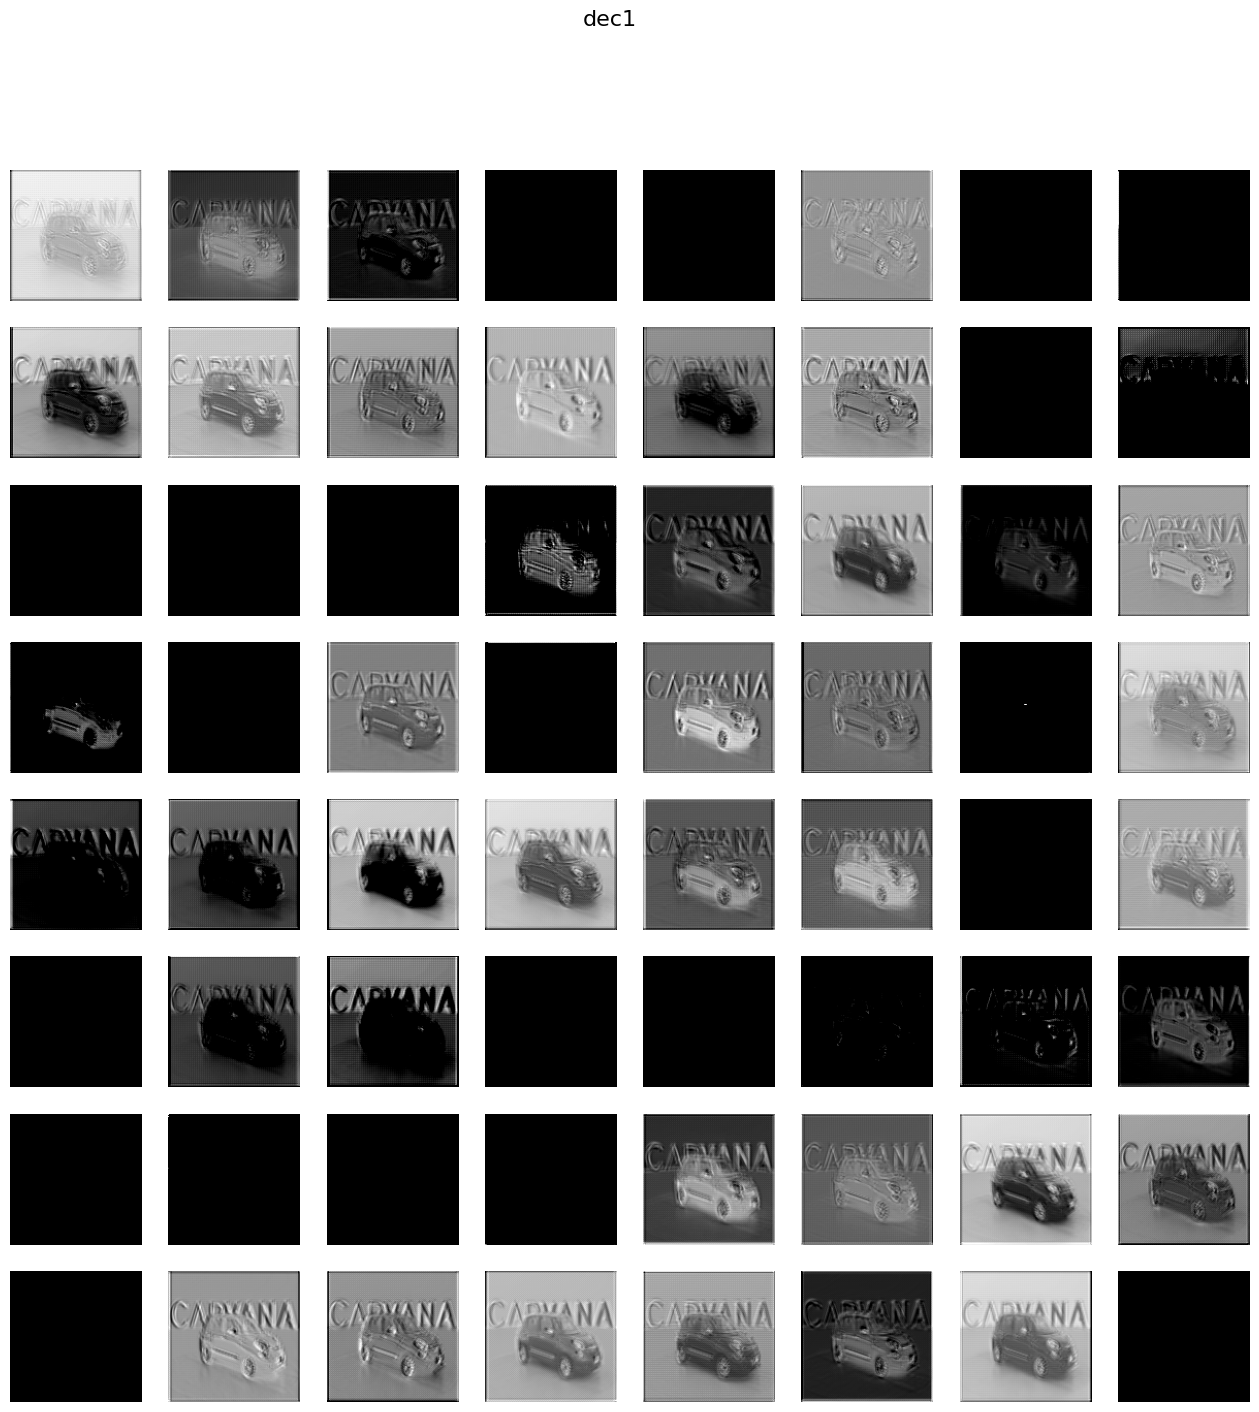

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

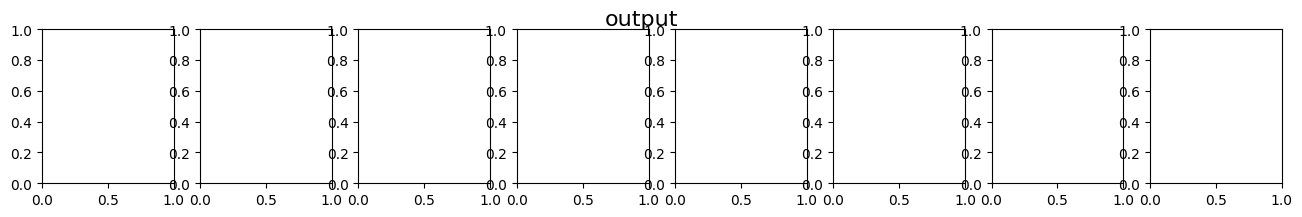

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
import os

def get_random_image(dataset, idx):
    """Retrieve a random image from the dataset."""
    return dataset[idx]

def visualize_feature_maps(feature_maps, title="Feature Maps"):
    """Visualize the feature maps."""
    num_maps = feature_maps.shape[1]
    size = feature_maps.shape[2]
    num_cols = 8
    num_rows = int(np.ceil(num_maps / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    fig.suptitle(title, fontsize=16)

    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            if idx < num_maps:
                ax = axes[i, j]
                ax.imshow(feature_maps[0, idx, :, :].detach().cpu().numpy(), cmap='gray')
                ax.axis('off')
            else:
                axes[i, j].axis('off')

    plt.show()

def visualize_random_image_and_features(model, dataset, device='cpu'):
    """Visualize a random image and its feature maps."""
    idx = np.random.randint(len(dataset))
    image, _ = get_random_image(dataset, idx)
    image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

    # Visualize the feature maps for the random image
    for layer_name, feature_map in model.features.items():
        visualize_feature_maps(feature_map, title=layer_name)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Assuming you have already defined `full_dataset` and split it into `train_dataset` and `test_dataset`
print("Visualizing a random image and its feature maps from the training dataset:")
visualize_random_image_and_features(model, train_dataset, device=device)

print("Visualizing a random image and its feature maps from the test dataset:")
visualize_random_image_and_features(model, test_dataset, device=device)



In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, random_split, Dataset
import os

# Assuming your model and dataset are defined
def visualize_random_image_and_features(model, dataset, device):
    # Set the model to evaluation mode
    model.eval()

    # Retrieve a random image from the dataset
    idx = np.random.randint(0, len(dataset))
    image, _ = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        x1 = model.down_conv_1(image)
        x2 = model.max_pool_2x2(x1)
        x3 = model.down_conv_2(x2)
        x4 = model.max_pool_2x2(x3)
        x5 = model.down_conv_3(x4)
        x6 = model.max_pool_2x2(x5)
        x7 = model.down_conv_4(x6)
        x8 = model.max_pool_2x2(x7)
        x9 = model.down_conv_5(x8)

        # Collect feature maps from various layers
        feature_maps = [x1, x2, x3, x4, x5, x6, x7, x8, x9]

        # Visualize and save feature maps
        for i, feature_map in enumerate(feature_maps):
            num_maps = feature_map.size(1)  # Number of channels
            for j in range(num_maps):
                plt.figure()
                plt.imshow(feature_map[0, j].cpu().numpy(), cmap='gray')
                plt.title(f'Layer {i} - Channel {j}')
                plt.axis('off')
                plt.savefig(f'feature_map_{i}_{j}.png')
                plt.close()

        return [f'feature_map_{i}_{j}.png' for i in range(len(feature_maps)) for j in range(feature_maps[i].size(1))]

# Example usage
feature_map_files = visualize_random_image_and_features(model, train_dataset, device=device)


In [ ]:
from google.colab import files

def download_images(files_list):
    for file_name in files_list:
        files.download(file_name)
        print(f"Downloaded {file_name}")

# Download the saved images
download_images(feature_map_files)

